# Num iterations to convergence
Created 02/10/2025

Objectives:
* Just run the algorithms a number of times to characterise how many iterations it takes until convergence.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../../")

In [54]:
import time
from itertools import chain
import re

from collections import (
    Counter,
    namedtuple,
    defaultdict
)

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [50]:
import pandas as pd
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


In [7]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    get_right_identity_environment_from_tp_tensor,
    multiply_stacked_unitaries_against_mps,
    inner_product_b_tensors,
    get_npc_identity_operator
)

from SPTOptimization.Optimizers.MPSBrickSolver import(
    MPSBrickSolver
)

# Load data

In [11]:
DATA_DIR_1 = r"../../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [12]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [13]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

In [14]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [17]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for psi in loaded_data_triv_proj_rep.values()
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 4200})

In [18]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for psi in loaded_data_non_triv_proj_rep.values()
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 4200})

# Definitions

In [19]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [20]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [21]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [22]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [23]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [24]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [25]:
fermionic_np_symmetries = [np_I, np_JW]

In [26]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [27]:
npc_JW = fermionic_npc_symmetries[1]

In [28]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [29]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [31]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )
    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    # Expand the d=4 qudit sites into 2 qubits.
    even_left_sites = [
        i for i in range(leftmost_symmetry_site - num_boundary_sites, leftmost_symmetry_site)
        if (i % 2 == 0)
    ]

    even_right_sites = [
        i for i in range(
            leftmost_symmetry_site + num_symmetry_sites,
            leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites
        )
        if (i % 2 == 0)
    ]

    for s in ['k', 'b']:
        left_sites = [even_left_sites[0], even_right_sites[0]]
        for i in left_sites:

            t = tnc.tensor_map[list(tnc.ind_map[f'{s}{i}'])[0]]
            tr = tnc.tensor_map[list(tnc.ind_map[f'{s}{i+1}'])[0]]
            vr = [
                ind for ind in t.inds if ind in tr.inds
            ][0]
            vl = [
                ind for ind in t.inds
                if ind not in [vr, f'{s}{i}']
            ]
        
            t.unfuse(
                {f'{s}{i}': [f'{s}{i}-0', f'{s}{i}-1']},
                {f'{s}{i}': [2, 2]},
                inplace=True
            )

            #t.split([f'{s}{i}-0', vl])

        right_sites = [even_left_sites[-1], even_right_sites[-1]]
        for i in right_sites:

            t = tnc.tensor_map[list(tnc.ind_map[f'{s}{i}'])[0]]
            tl = tnc.tensor_map[list(tnc.ind_map[f'{s}{i-1}'])[0]]
            vl = [
                ind for ind in t.inds if ind in tl.inds
            ][0]
        
            t.unfuse(
                {f'{s}{i}': [f'{s}{i}-0', f'{s}{i}-1']},
                {f'{s}{i}': [2, 2]},
                inplace=True
            )

            #t.split([f'{s}{i}-0', vl])

        inner_sites = [
            *even_left_sites[1:-1],
            *even_right_sites[1:-1]
        ]

        for i in inner_sites:

            t = tnc.tensor_map[list(tnc.ind_map[f'{s}{i}'])[0]]
            tl = tnc.tensor_map[list(tnc.ind_map[f'{s}{i-1}'])[0]]
            vl = [
                ind for ind in t.inds
                if ind not in [vr, f'{s}{i}']
            ]
        
            t.unfuse(
                {f'{s}{i}': [f'{s}{i}-0', f'{s}{i}-1']},
                {f'{s}{i}': [2, 2]},
                inplace=True
            )

            #t.split([f'{s}{i}-0', vl])
        
    return tnc

## Optimisation functions

In [32]:
def loss(circ_pair, problem_rdm):
    c = (problem_rdm & circ_pair)^...

    c_abs_squared = (
        c
        *jnp.conjugate(c)
    )
    c_abs_squared = jnp.real(c_abs_squared)

    out = 1-c_abs_squared

    return out

## Gate functions

In [33]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist='uniform')
        circ.apply_gate(
            'U3',
            *params,
            i,
            gate_round=gate_round,
            parametrize=True
        )

In [34]:
def two_qubit_layer(circ, gate2='CZ', start=0, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    num_sites = circ.N # Assuming this is even
    sites = [
        i % num_sites
        for i in range(start, start + num_sites)
    ]
    
    site_pairs = list(zip(sites[::2], sites[1::2]))

    for i, j in site_pairs:
        circ.apply_gate(
            gate2,
            i,
            j,
            gate_round=gate_round
        )

    if (num_sites % 2) == 1:
        circ.apply_gate(
            gate2,
            sites[0],
            sites[-1],
            gate_round=gate_round
        )

In [35]:
def ansatz_circuit(n, depth, first_site=0, gate2='CZ', gate_tag=None,
                   **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs)

    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)

        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r, start=r % 2)

    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)

    circ = circ.uni

    no_labels_index_map = dict()

    old_site = 0
    new_site = first_site

    while old_site < n:
        if (new_site % 2) == 0:
            no_labels_index_map[f'{old_site}'] = f'{new_site}-0'
            no_labels_index_map[f'{old_site+1}'] = f'{new_site}-1'
            old_site += 2
        else:
            no_labels_index_map[f'{old_site}'] = f'{new_site}'
            old_site += 1
        new_site += 1

    assert old_site == n
    
    if gate_tag is not None:
        for t in circ.tensors:
            t.add_tag(gate_tag)

    index_labels = ['k', 'b']

    # Include labels in map
    index_map = {
        f'{l}{k}': f'{l}{v}'
        for k, v in no_labels_index_map.items()
        for l in index_labels
    }

    circ.reindex(index_map, inplace=True)

    return circ

In [36]:
def ansatz_circuit_pair(leftmost_symmetry_site,
    num_symmetry_sites, num_boundary_sites, depth,
    gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    left_start_site = leftmost_symmetry_site-num_boundary_sites
    right_start_site = leftmost_symmetry_site+num_symmetry_sites

    left_num_expanded_boundary_sites = sum(
        2 if (i % 2 == 0) else 1
        for i in range(left_start_site, left_start_site + num_boundary_sites)
    )

    left_circuit = ansatz_circuit(
        left_num_expanded_boundary_sites,
        depth,
        first_site=left_start_site,
        gate2=gate2,
        gate_tag='left',
        **kwargs
    )

    right_num_expanded_boundary_sites = sum(
        2 if (i % 2 == 0) else 1
        for i in range(right_start_site, right_start_site + num_boundary_sites)
    )

    right_circuit = ansatz_circuit(
        right_num_expanded_boundary_sites,
        depth,
        first_site=right_start_site,
        gate2=gate2,
        gate_tag='right',
        **kwargs
    )

    circ_pair = (left_circuit & right_circuit)

    return circ_pair

In [37]:
def split_circ_pair(circ_pair):
    left_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['left']))
    )

    right_circuit = qtn.TensorNetwork(
        list(map(circ_pair.tensor_map.__getitem__, circ_pair.tag_map['right']))
    )

    return (left_circuit, right_circuit)

# Single case

In [39]:
num_boundary_sites=4
depth=6
left_most_symmetry_site=60
num_symmetry_sites=80
bond_dimension=6

total_physical_dim = 2**6

In [38]:
psi = loaded_data_non_triv_proj_rep[0.45]

In [40]:
mps_psi = psi

In [41]:
psi_arrays = list()
psi_arrays.append(mps_psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, mps_psi.L-1):
    psi_arrays.append(mps_psi.get_B(i).to_ndarray())
psi_arrays.append(mps_psi.get_B(mps_psi.L-1)[..., 0].to_ndarray())

q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(psi_arrays, shape='lpr')
)

In [43]:
symms = symmetry_actions[1][1]

symmetry_site_pairs = (
    [(i, symms[0]) for i in range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites, 2)]
    + [(i, symms[1]) for i in range(left_most_symmetry_site+1, left_most_symmetry_site+num_symmetry_sites+1, 2)]
)

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    left_most_symmetry_site,
    num_symmetry_sites,
    num_boundary_sites
)

In [45]:
num_initializations = 30
num_iterations = int(1e4)

scores = np.zeros((num_initializations, num_iterations))

for i in range(num_initializations):
    if (i % 5) == 0:
        print(i)

    circ_pair = ansatz_circuit_pair(
        left_most_symmetry_site,
        num_symmetry_sites,
        num_boundary_sites,
        depth
    )

    tnopt = qtn.TNOptimizer(
        circ_pair,                        # the tensor network we want to optimize
        loss,                     # the function we want to minimize
        loss_constants={'problem_rdm': problem_rdm},  # supply U to the loss function as a constant TN
        tags=['U3'],              # only optimize U3 tensors
        #autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
        optimizer='COBYLA',     # the optimization algorithm
        progbar=False
    )
    
    circ_opt = tnopt.optimize(
        n=num_iterations,
        jac=False,
        hessp=False
    )

    scores[i] = tnopt.losses

0


/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


5
10
15
20
25


# Analyse

In [46]:
scores.shape

(30, 10000)

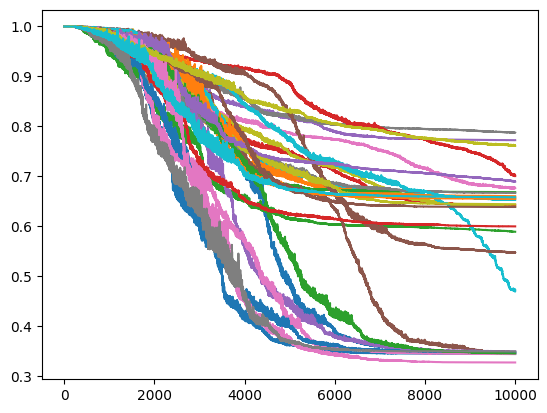

In [47]:
for l in scores:
    plt.plot(l)

In [48]:
best_scores = np.min(scores, axis=1)

In [51]:
pd.Series(best_scores).describe()

count    30.000000
mean      0.562130
std       0.156787
min       0.326723
25%       0.348864
50%       0.640275
75%       0.664774
max       0.787383
dtype: float64

(array([9., 0., 0., 1., 1., 2., 4., 9., 1., 3.]),
 array([0.32672292, 0.37278889, 0.41885487, 0.46492084, 0.51098682,
        0.55705279, 0.60311877, 0.64918474, 0.69525071, 0.74131669,
        0.78738266]),
 <BarContainer object of 10 artists>)

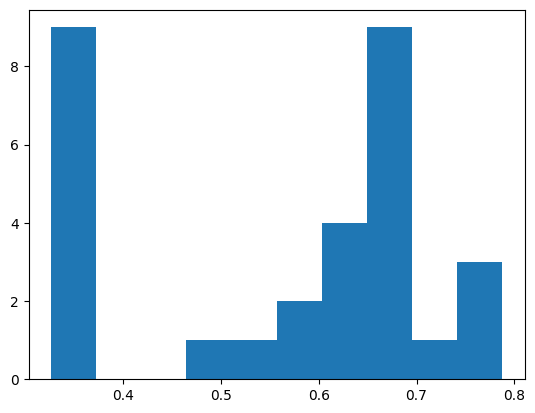

In [52]:
plt.hist(best_scores)

In [53]:
np.sum(best_scores < 0.4)

9

# How long does a single run take?

In [56]:
t0 = time.time()

circ_pair = ansatz_circuit_pair(
    left_most_symmetry_site,
    num_symmetry_sites,
    num_boundary_sites,
    depth
)

tnopt = qtn.TNOptimizer(
    circ_pair,                        # the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'problem_rdm': problem_rdm},  # supply U to the loss function as a constant TN
    tags=['U3'],              # only optimize U3 tensors
    #autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='COBYLA',     # the optimization algorithm
    progbar=False
)

circ_opt = tnopt.optimize(
    n=num_iterations,
    jac=False,
    hessp=False
)

t1 = time.time()

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/circuit.py:2587: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


In [57]:
t1-t0

184.69225907325745

# Conclusions

It takes about 3 mins per run, and multiple runs are needed. Typically about 8k iterations to convergence.